In [1]:
import os
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from analysis._utils import *
import yaml

In [2]:
config = OmegaConf.load("../conf/analysis.yaml")

In [3]:
configs = {}
for file_path in find_config_files("../logs/hydra/2023_04_13_04_38_22"):
    with open(file_path, 'r') as f:
        data = yaml.safe_load(f)
        parent_dir = os.path.dirname(file_path)
        if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
            loss_df = pd.read_csv(os.path.join(parent_dir, "loss_curves.csv"), index_col=0)
            loss = loss_df["centered_test_losses"][loss_df["centered_test_losses"].idxmin()]
            configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))

In [4]:
configs["../logs/hydra/2023_04_13_04_38_22/0"]

(0.10379674,
 {'preprocess': {'url': 'https://www.dropbox.com/s/lw9cblxawqsbr2w/opensource_data.zip?dl=1', 'zipfile': 'opensource_data.zip', 'dataset': 'all', 'raw_dir': 'data/raw', 'smooth': 'fft'}, 'dataset': {'name': 'Kato2015'}, 'model': {'type': 'NetworkLSTM', 'input_size': 302, 'hidden_size': 128, 'num_layers': 1, 'loss': 'l1'}, 'visualize': {'log_dir': 'logs/hydra/2023_04_13_04_38_22/0', 'worm': 'worm1', 'neuron': 'AVAL'}, 'train': {'learn_rate': 0.01, 'seq_len': 99, 'k_splits': 2, 'epochs': 100, 'save_freq': 100, 'smooth_data': True, 'reverse': False, 'num_batches': 4, 'train_size': 12, 'test_size': 492, 'shuffle': True, 'tau_in': 1, 'tau_out': 1, 'optimizer': 'Adam'}, 'globals': {'use_residual': False, 'shuffle': False}, 'timestamp': '2023_04_13_04_38_39', 'num_unique_worms': 12, 'worm_timesteps': 1188})

In [5]:
trailing_dict = {}
for key, value in configs.items():
    dataset_name = value[1]["dataset"]["name"]
    train_size = value[1]["train"]["train_size"]
    loss = value[0]
    print(f"{dataset_name} {train_size} {loss}")
    if dataset_name in trailing_dict.keys():
        trailing_dict[dataset_name].update({train_size: loss})
    else:
        trailing_dict[dataset_name] = {train_size: loss}

Kato2015 12 0.10379674
Kato2015 15160 0.07705193
Kato2015 9996 0.07017329
Kato2015 48 0.08444889
Kato2015 996 0.07005784
Kato2015 492 0.07782983
Kato2015 96 0.079199284
Kato2015 4992 0.073489524


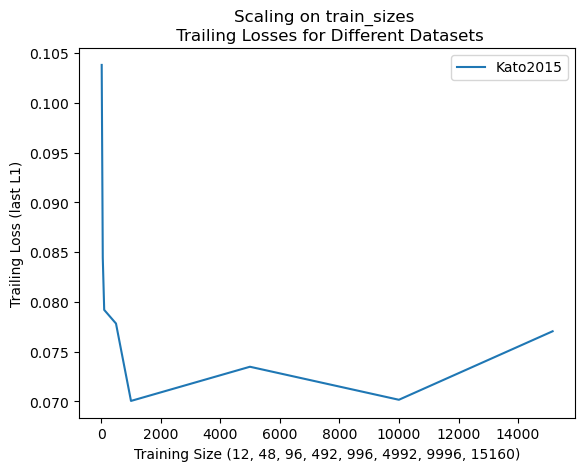

In [6]:
x = []
for dataset_name, dataset_dict in trailing_dict.items():
    if dataset_name == "Flavell2023":
        continue
    sorted_x, sorted_y = zip(*sorted(zip(list(dataset_dict.keys()), list(dataset_dict.values()))))
    x = sorted_x
    plt.plot(sorted_x, sorted_y, label=dataset_name)

plt.legend()
plt.xlabel("Training Size " + str(x))
plt.ylabel("Trailing Loss (last L1)")
plt.title("Scaling on train_sizes \n Trailing Losses for Different Datasets")
plt.savefig("../analysis/figures/trailing_loss.png")

In [7]:
def plot_trailing_loss_vs_parameter_legend(config_pardir, parameter, legend):
    configs = {}
    # go through all the config files and get the parameters and the loss
    for file_path in find_config_files(config_pardir):
        with open(file_path, 'r') as f:
            data = yaml.safe_load(f)
            parent_dir = os.path.dirname(file_path)
            if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
                loss_df = pd.read_csv(os.path.join(parent_dir, "loss_curves.csv"), index_col=0)
                loss = loss_df["centered_test_losses"][loss_df["centered_test_losses"].idxmin()]
                configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))

    parameters = parameter.split(".")
    param_name = parameters[1]
    legends = legend.split(".")

    # get the trailing loss for each parameter value
    trailing_dict = {}
    for key, value in configs.items():
        legend_name = value[1][legends[0]][legends[1]]
        param_value = value[1][parameters[0]][parameters[1]]
        loss = value[0]
        print(f"{legend_name} {param_value} {loss}")
        if legend_name in trailing_dict.keys():
            trailing_dict[legend_name].update({param_value: loss})
        else:
            trailing_dict[legend_name] = {param_value: loss}

    # plot the trailing loss for each parameter value
    x = []
    for para_n, val_dict in trailing_dict.items():
        sorted_x, sorted_y = zip(*sorted(zip(list(val_dict.keys()), list(val_dict.values()))))
        x = sorted_x
        plt.plot(sorted_x, sorted_y, label=para_n)

    plt.legend()
    plt.xlabel("Training Size " + str(x))
    plt.ylabel("Trailing Loss (last L1)")
    plt.title("Scaling on train_sizes \n Trailing Losses for Different " + str(legends[1]) + "s")
    plt.savefig("../analysis/figures/trailing_loss_on_"+ str(param_name) + ".png")


Kato2015 12 0.10379674
Kato2015 15160 0.07705193
Kato2015 9996 0.07017329
Kato2015 48 0.08444889
Kato2015 996 0.07005784
Kato2015 492 0.07782983
Kato2015 96 0.079199284
Kato2015 4992 0.073489524


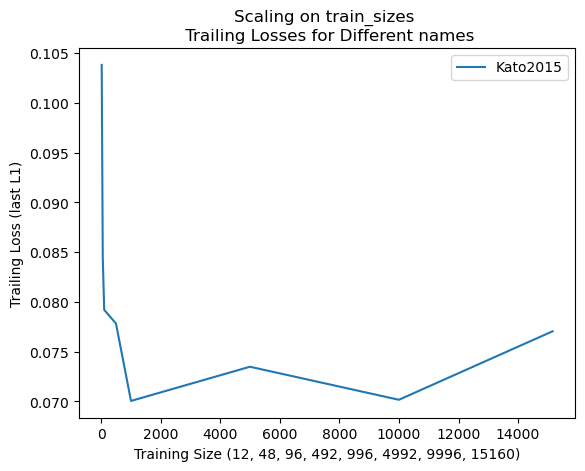

In [8]:
plot_trailing_loss_vs_parameter_legend("../logs/hydra/2023_04_13_04_38_22", "train.train_size", "dataset.name")